In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run1.framed",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 154325,
    "seed": 154325,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 751.6263, train_label_loss: 2.8174, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 11347.8009, train_label_loss: 2.6664, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 11676.9707, train_label_loss: 2.6441, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 11722.1144, train_label_loss: 2.4772, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 11746.5327, train_label_loss: 2.3638, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 11696.7725, train_label_loss: 2.2743, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 11683.1582, train_label_loss: 2.1296, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 11730.6856, train_label_loss: 1.8910, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 11561.0062, train_label_loss: 1.7669, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 11634.2331, train_label_loss: 1.6328, 


epoch: 1, source_val_acc_label: 0.5788, source_val_label_loss: 1.4578, target_val_acc_label: 0.5788, target_val_label_loss: 1.4578, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 55.7621, train_label_loss: 1.6356, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 11489.6055, train_label_loss: 1.2942, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 11663.6142, train_label_loss: 1.3902, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 11674.2012, train_label_loss: 1.3572, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 11600.5739, train_label_loss: 1.1235, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 11722.2789, train_label_loss: 0.9907, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 11524.0570, train_label_loss: 1.0573, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 11596.3016, train_label_loss: 0.8958, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 11608.9305, train_label_loss: 0.8719, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 11402.7474, train_label_loss: 0.7316, 


epoch: 2, source_val_acc_label: 0.8067, source_val_label_loss: 0.7057, target_val_acc_label: 0.8067, target_val_label_loss: 0.7057, 


New best
epoch: 3, [batch: 1 / 1400], examples_per_second: 64.4482, train_label_loss: 0.5882, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 11619.3992, train_label_loss: 0.6370, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 12262.6642, train_label_loss: 0.6446, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 12423.5597, train_label_loss: 0.5146, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 12169.5618, train_label_loss: 0.4999, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 12235.6828, train_label_loss: 0.5472, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 12068.3097, train_label_loss: 0.4903, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 12336.8666, train_label_loss: 0.5118, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 12160.7429, train_label_loss: 0.4893, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 11595.3034, train_label_loss: 0.3724, 


epoch: 3, source_val_acc_label: 0.9075, source_val_label_loss: 0.3814, target_val_acc_label: 0.9075, target_val_label_loss: 0.3814, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 56.4363, train_label_loss: 0.4178, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 10536.5849, train_label_loss: 0.3936, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 10674.7635, train_label_loss: 0.3644, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 10683.5988, train_label_loss: 0.3963, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 10721.6222, train_label_loss: 0.3687, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 10602.6659, train_label_loss: 0.3404, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 10591.0693, train_label_loss: 0.3432, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 10751.9887, train_label_loss: 0.3695, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 10593.9086, train_label_loss: 0.2674, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 10733.4070, train_label_loss: 0.3175, 


epoch: 4, source_val_acc_label: 0.9019, source_val_label_loss: 0.3411, target_val_acc_label: 0.9019, target_val_label_loss: 0.3411, 


epoch: 5, [batch: 1 / 1400], examples_per_second: 57.9166, train_label_loss: 0.2437, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 10668.6660, train_label_loss: 0.3203, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 10684.1258, train_label_loss: 0.2092, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 10745.9782, train_label_loss: 0.2653, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 10681.4065, train_label_loss: 0.2410, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 10758.9900, train_label_loss: 0.3191, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 10672.8612, train_label_loss: 0.1791, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 10757.5795, train_label_loss: 0.2231, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 10708.1788, train_label_loss: 0.2393, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 10720.7215, train_label_loss: 0.2356, 


epoch: 5, source_val_acc_label: 0.9267, source_val_label_loss: 0.2644, target_val_acc_label: 0.9267, target_val_label_loss: 0.2644, 


New best
epoch: 6, [batch: 1 / 1400], examples_per_second: 57.4268, train_label_loss: 0.2665, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 10562.3462, train_label_loss: 0.2407, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 10719.5304, train_label_loss: 0.1934, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 10689.7298, train_label_loss: 0.2436, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 10650.8980, train_label_loss: 0.2708, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 10704.6254, train_label_loss: 0.3063, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 10695.1495, train_label_loss: 0.2065, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 10684.0256, train_label_loss: 0.4229, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 10717.8123, train_label_loss: 0.1654, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 10697.5287, train_label_loss: 0.2186, 


epoch: 6, source_val_acc_label: 0.9424, source_val_label_loss: 0.2195, target_val_acc_label: 0.9424, target_val_label_loss: 0.2195, 


New best
epoch: 7, [batch: 1 / 1400], examples_per_second: 57.2883, train_label_loss: 0.2528, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 10676.5725, train_label_loss: 0.1647, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 10730.5721, train_label_loss: 0.3114, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 10722.8642, train_label_loss: 0.1873, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 10711.8185, train_label_loss: 0.1591, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 10684.7516, train_label_loss: 0.2103, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 10628.7078, train_label_loss: 0.1475, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 10770.6457, train_label_loss: 0.2650, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 10623.4679, train_label_loss: 0.1907, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 10694.9593, train_label_loss: 0.1953, 


epoch: 7, source_val_acc_label: 0.9441, source_val_label_loss: 0.1925, target_val_acc_label: 0.9441, target_val_label_loss: 0.1925, 


New best
epoch: 8, [batch: 1 / 1400], examples_per_second: 57.4411, train_label_loss: 0.1634, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 10644.4106, train_label_loss: 0.2016, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 10740.9290, train_label_loss: 0.2847, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 10706.6321, train_label_loss: 0.1625, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 10723.2498, train_label_loss: 0.1385, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 10664.8727, train_label_loss: 0.1663, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 10700.8473, train_label_loss: 0.1364, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 10713.0644, train_label_loss: 0.1952, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 10717.5555, train_label_loss: 0.1700, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 10714.7092, train_label_loss: 0.1699, 


epoch: 8, source_val_acc_label: 0.9382, source_val_label_loss: 0.5102, target_val_acc_label: 0.9382, target_val_label_loss: 0.5102, 


epoch: 9, [batch: 1 / 1400], examples_per_second: 57.6901, train_label_loss: 0.1804, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 10668.9482, train_label_loss: 0.2342, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 10705.7796, train_label_loss: 0.2204, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 10718.0385, train_label_loss: 0.1641, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 10722.8214, train_label_loss: 0.1514, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 10728.9853, train_label_loss: 0.1928, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 10720.1970, train_label_loss: 0.2033, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 10635.1597, train_label_loss: 0.3592, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 11449.6433, train_label_loss: 0.1524, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 11755.8493, train_label_loss: 0.1681, 


epoch: 9, source_val_acc_label: 0.9395, source_val_label_loss: 0.2438, target_val_acc_label: 0.9395, target_val_label_loss: 0.2438, 


epoch: 10, [batch: 1 / 1400], examples_per_second: 65.1091, train_label_loss: 0.2121, 


epoch: 10, [batch: 140 / 1400], examples_per_second: 11700.4127, train_label_loss: 0.1396, 


epoch: 10, [batch: 280 / 1400], examples_per_second: 11691.6380, train_label_loss: 0.1848, 


epoch: 10, [batch: 420 / 1400], examples_per_second: 11776.4327, train_label_loss: 0.1354, 


epoch: 10, [batch: 560 / 1400], examples_per_second: 11745.7323, train_label_loss: 0.1264, 


epoch: 10, [batch: 700 / 1400], examples_per_second: 11740.0559, train_label_loss: 0.1497, 


epoch: 10, [batch: 840 / 1400], examples_per_second: 11783.2674, train_label_loss: 0.0700, 


epoch: 10, [batch: 980 / 1400], examples_per_second: 11735.4202, train_label_loss: 0.1530, 


epoch: 10, [batch: 1120 / 1400], examples_per_second: 11740.4557, train_label_loss: 0.2516, 


epoch: 10, [batch: 1260 / 1400], examples_per_second: 11772.1535, train_label_loss: 0.1709, 


epoch: 10, source_val_acc_label: 0.9524, source_val_label_loss: 0.1516, target_val_acc_label: 0.9524, target_val_label_loss: 0.1516, 


New best
epoch: 11, [batch: 1 / 1400], examples_per_second: 64.3341, train_label_loss: 0.1249, 


epoch: 11, [batch: 140 / 1400], examples_per_second: 11673.6062, train_label_loss: 0.1314, 


epoch: 11, [batch: 280 / 1400], examples_per_second: 11713.8971, train_label_loss: 0.1332, 


epoch: 11, [batch: 420 / 1400], examples_per_second: 11827.3639, train_label_loss: 0.2633, 


epoch: 11, [batch: 560 / 1400], examples_per_second: 11753.5679, train_label_loss: 0.1609, 


epoch: 11, [batch: 700 / 1400], examples_per_second: 11726.9207, train_label_loss: 0.1495, 


epoch: 11, [batch: 840 / 1400], examples_per_second: 11764.6135, train_label_loss: 0.1378, 


epoch: 11, [batch: 980 / 1400], examples_per_second: 11739.1941, train_label_loss: 0.1026, 


epoch: 11, [batch: 1120 / 1400], examples_per_second: 11768.4984, train_label_loss: 0.1650, 


epoch: 11, [batch: 1260 / 1400], examples_per_second: 11745.1156, train_label_loss: 0.0946, 


epoch: 11, source_val_acc_label: 0.9570, source_val_label_loss: 0.3312, target_val_acc_label: 0.9570, target_val_label_loss: 0.3312, 


New best
epoch: 12, [batch: 1 / 1400], examples_per_second: 64.2018, train_label_loss: 0.1032, 


epoch: 12, [batch: 140 / 1400], examples_per_second: 11695.3865, train_label_loss: 0.2257, 


epoch: 12, [batch: 280 / 1400], examples_per_second: 11742.1963, train_label_loss: 0.1735, 


epoch: 12, [batch: 420 / 1400], examples_per_second: 11757.4014, train_label_loss: 0.1793, 


epoch: 12, [batch: 560 / 1400], examples_per_second: 11812.1204, train_label_loss: 0.1954, 


epoch: 12, [batch: 700 / 1400], examples_per_second: 11791.0644, train_label_loss: 0.1412, 


epoch: 12, [batch: 840 / 1400], examples_per_second: 11758.6135, train_label_loss: 0.1045, 


epoch: 12, [batch: 980 / 1400], examples_per_second: 11774.0751, train_label_loss: 0.1065, 


epoch: 12, [batch: 1120 / 1400], examples_per_second: 11724.1860, train_label_loss: 0.1031, 


epoch: 12, [batch: 1260 / 1400], examples_per_second: 11772.5297, train_label_loss: 0.0640, 


epoch: 12, source_val_acc_label: 0.9484, source_val_label_loss: 0.2119, target_val_acc_label: 0.9484, target_val_label_loss: 0.2119, 


epoch: 13, [batch: 1 / 1400], examples_per_second: 65.2311, train_label_loss: 0.1342, 


epoch: 13, [batch: 140 / 1400], examples_per_second: 11721.2327, train_label_loss: 0.0743, 


epoch: 13, [batch: 280 / 1400], examples_per_second: 11771.7461, train_label_loss: 0.1232, 


epoch: 13, [batch: 420 / 1400], examples_per_second: 11645.4849, train_label_loss: 0.1410, 


epoch: 13, [batch: 560 / 1400], examples_per_second: 11724.9780, train_label_loss: 0.1195, 


epoch: 13, [batch: 700 / 1400], examples_per_second: 11684.8110, train_label_loss: 0.0675, 


epoch: 13, [batch: 840 / 1400], examples_per_second: 11890.0028, train_label_loss: 0.1483, 


epoch: 13, [batch: 980 / 1400], examples_per_second: 12391.3583, train_label_loss: 0.1031, 


epoch: 13, [batch: 1120 / 1400], examples_per_second: 11955.0846, train_label_loss: 0.0938, 


epoch: 13, [batch: 1260 / 1400], examples_per_second: 11735.4476, train_label_loss: 0.2134, 


epoch: 13, source_val_acc_label: 0.9483, source_val_label_loss: 0.2563, target_val_acc_label: 0.9483, target_val_label_loss: 0.2563, 


epoch: 14, [batch: 1 / 1400], examples_per_second: 65.3576, train_label_loss: 0.1528, 


epoch: 14, [batch: 140 / 1400], examples_per_second: 11703.4276, train_label_loss: 0.0896, 


epoch: 14, [batch: 280 / 1400], examples_per_second: 11831.3220, train_label_loss: 0.0908, 


epoch: 14, [batch: 420 / 1400], examples_per_second: 11817.3613, train_label_loss: 0.0844, 


epoch: 14, [batch: 560 / 1400], examples_per_second: 11782.1573, train_label_loss: 0.1057, 


epoch: 14, [batch: 700 / 1400], examples_per_second: 11770.2603, train_label_loss: 0.0752, 


epoch: 14, [batch: 840 / 1400], examples_per_second: 11730.2498, train_label_loss: 0.0695, 


epoch: 14, [batch: 980 / 1400], examples_per_second: 11728.6207, train_label_loss: 0.1263, 


epoch: 14, [batch: 1120 / 1400], examples_per_second: 11725.8669, train_label_loss: 0.1345, 


epoch: 14, [batch: 1260 / 1400], examples_per_second: 11754.4318, train_label_loss: 0.1204, 


epoch: 14, source_val_acc_label: 0.9581, source_val_label_loss: 0.1766, target_val_acc_label: 0.9581, target_val_label_loss: 0.1766, 


New best
epoch: 15, [batch: 1 / 1400], examples_per_second: 64.5873, train_label_loss: 0.1865, 


epoch: 15, [batch: 140 / 1400], examples_per_second: 11639.5232, train_label_loss: 0.0787, 


epoch: 15, [batch: 280 / 1400], examples_per_second: 11632.8844, train_label_loss: 0.0969, 


epoch: 15, [batch: 420 / 1400], examples_per_second: 11699.7275, train_label_loss: 0.0505, 


epoch: 15, [batch: 560 / 1400], examples_per_second: 11755.4816, train_label_loss: 0.1129, 


epoch: 15, [batch: 700 / 1400], examples_per_second: 11737.2693, train_label_loss: 0.0881, 


epoch: 15, [batch: 840 / 1400], examples_per_second: 11805.2559, train_label_loss: 0.0554, 


epoch: 15, [batch: 980 / 1400], examples_per_second: 11732.0588, train_label_loss: 0.1034, 


epoch: 15, [batch: 1120 / 1400], examples_per_second: 11756.8276, train_label_loss: 0.0851, 


epoch: 15, [batch: 1260 / 1400], examples_per_second: 11792.6332, train_label_loss: 0.0715, 


epoch: 15, source_val_acc_label: 0.9597, source_val_label_loss: 0.3291, target_val_acc_label: 0.9597, target_val_label_loss: 0.3291, 


New best
epoch: 16, [batch: 1 / 1400], examples_per_second: 64.9619, train_label_loss: 0.0632, 


epoch: 16, [batch: 140 / 1400], examples_per_second: 11765.2898, train_label_loss: 0.0669, 


epoch: 16, [batch: 280 / 1400], examples_per_second: 11718.3477, train_label_loss: 0.1376, 


epoch: 16, [batch: 420 / 1400], examples_per_second: 11764.8456, train_label_loss: 0.1323, 


epoch: 16, [batch: 560 / 1400], examples_per_second: 11789.4498, train_label_loss: 0.1781, 


epoch: 16, [batch: 700 / 1400], examples_per_second: 11755.0054, train_label_loss: 0.1436, 


epoch: 16, [batch: 840 / 1400], examples_per_second: 11745.1505, train_label_loss: 0.0504, 


epoch: 16, [batch: 980 / 1400], examples_per_second: 11704.8236, train_label_loss: 0.0492, 


epoch: 16, [batch: 1120 / 1400], examples_per_second: 11804.4939, train_label_loss: 0.1376, 


epoch: 16, [batch: 1260 / 1400], examples_per_second: 11729.5725, train_label_loss: 0.1387, 


epoch: 16, source_val_acc_label: 0.9548, source_val_label_loss: 0.2216, target_val_acc_label: 0.9548, target_val_label_loss: 0.2216, 


epoch: 17, [batch: 1 / 1400], examples_per_second: 65.7018, train_label_loss: 0.1259, 


epoch: 17, [batch: 140 / 1400], examples_per_second: 11704.2059, train_label_loss: 0.1332, 


epoch: 17, [batch: 280 / 1400], examples_per_second: 11756.4267, train_label_loss: 0.0595, 


epoch: 17, [batch: 420 / 1400], examples_per_second: 11739.7533, train_label_loss: 0.1194, 


epoch: 17, [batch: 560 / 1400], examples_per_second: 11707.5128, train_label_loss: 0.0610, 


epoch: 17, [batch: 700 / 1400], examples_per_second: 11756.2410, train_label_loss: 0.0605, 


epoch: 17, [batch: 840 / 1400], examples_per_second: 11750.3487, train_label_loss: 0.0544, 


epoch: 17, [batch: 980 / 1400], examples_per_second: 11811.6173, train_label_loss: 0.1494, 


epoch: 17, [batch: 1120 / 1400], examples_per_second: 11677.9812, train_label_loss: 0.0859, 


epoch: 17, [batch: 1260 / 1400], examples_per_second: 11827.2224, train_label_loss: 0.1474, 


epoch: 17, source_val_acc_label: 0.9542, source_val_label_loss: 0.1465, target_val_acc_label: 0.9542, target_val_label_loss: 0.1465, 


epoch: 18, [batch: 1 / 1400], examples_per_second: 65.6758, train_label_loss: 0.0588, 


epoch: 18, [batch: 140 / 1400], examples_per_second: 11709.6880, train_label_loss: 0.0537, 


epoch: 18, [batch: 280 / 1400], examples_per_second: 11737.8283, train_label_loss: 0.0348, 


epoch: 18, [batch: 420 / 1400], examples_per_second: 11728.6189, train_label_loss: 0.1234, 


epoch: 18, [batch: 560 / 1400], examples_per_second: 11797.2087, train_label_loss: 0.0716, 


epoch: 18, [batch: 700 / 1400], examples_per_second: 11721.8822, train_label_loss: 0.0548, 


epoch: 18, [batch: 840 / 1400], examples_per_second: 11806.6374, train_label_loss: 0.0549, 


epoch: 18, [batch: 980 / 1400], examples_per_second: 11778.2302, train_label_loss: 0.0578, 


epoch: 18, [batch: 1120 / 1400], examples_per_second: 11758.9686, train_label_loss: 0.1404, 


epoch: 18, [batch: 1260 / 1400], examples_per_second: 11763.6524, train_label_loss: 0.1108, 


epoch: 18, source_val_acc_label: 0.9584, source_val_label_loss: 0.2806, target_val_acc_label: 0.9584, target_val_label_loss: 0.2806, 


epoch: 19, [batch: 1 / 1400], examples_per_second: 65.3481, train_label_loss: 0.0552, 


epoch: 19, [batch: 140 / 1400], examples_per_second: 11729.9621, train_label_loss: 0.0584, 


epoch: 19, [batch: 280 / 1400], examples_per_second: 11823.9627, train_label_loss: 0.0818, 


epoch: 19, [batch: 420 / 1400], examples_per_second: 11752.4597, train_label_loss: 0.0609, 


epoch: 19, [batch: 560 / 1400], examples_per_second: 11786.7487, train_label_loss: 0.0777, 


epoch: 19, [batch: 700 / 1400], examples_per_second: 11694.2174, train_label_loss: 0.0855, 


epoch: 19, [batch: 840 / 1400], examples_per_second: 11749.3182, train_label_loss: 0.0839, 


epoch: 19, [batch: 980 / 1400], examples_per_second: 11767.4316, train_label_loss: 0.0908, 


epoch: 19, [batch: 1120 / 1400], examples_per_second: 11718.0792, train_label_loss: 0.1158, 


epoch: 19, [batch: 1260 / 1400], examples_per_second: 11717.6389, train_label_loss: 0.0656, 


epoch: 19, source_val_acc_label: 0.9616, source_val_label_loss: 0.1556, target_val_acc_label: 0.9616, target_val_label_loss: 0.1556, 


New best
epoch: 20, [batch: 1 / 1400], examples_per_second: 63.6669, train_label_loss: 0.1687, 


epoch: 20, [batch: 140 / 1400], examples_per_second: 11675.3175, train_label_loss: 0.0751, 


epoch: 20, [batch: 280 / 1400], examples_per_second: 12262.8222, train_label_loss: 0.0662, 


epoch: 20, [batch: 420 / 1400], examples_per_second: 12616.8515, train_label_loss: 0.0730, 


epoch: 20, [batch: 560 / 1400], examples_per_second: 12475.1744, train_label_loss: 0.0924, 


epoch: 20, [batch: 700 / 1400], examples_per_second: 12512.8109, train_label_loss: 0.0710, 


epoch: 20, [batch: 840 / 1400], examples_per_second: 12466.2338, train_label_loss: 0.1565, 


epoch: 20, [batch: 980 / 1400], examples_per_second: 12530.8621, train_label_loss: 0.0676, 


epoch: 20, [batch: 1120 / 1400], examples_per_second: 12603.4489, train_label_loss: 0.0454, 


epoch: 20, [batch: 1260 / 1400], examples_per_second: 12567.7851, train_label_loss: 0.0565, 


epoch: 20, source_val_acc_label: 0.9621, source_val_label_loss: 0.2631, target_val_acc_label: 0.9621, target_val_label_loss: 0.2631, 


New best
epoch: 21, [batch: 1 / 1400], examples_per_second: 56.7518, train_label_loss: 0.0860, 


epoch: 21, [batch: 140 / 1400], examples_per_second: 10616.0032, train_label_loss: 0.0616, 


epoch: 21, [batch: 280 / 1400], examples_per_second: 10712.3758, train_label_loss: 0.0963, 


epoch: 21, [batch: 420 / 1400], examples_per_second: 10701.3592, train_label_loss: 0.0806, 


epoch: 21, [batch: 560 / 1400], examples_per_second: 10638.9171, train_label_loss: 0.0801, 


epoch: 21, [batch: 700 / 1400], examples_per_second: 10710.2326, train_label_loss: 0.1130, 


epoch: 21, [batch: 840 / 1400], examples_per_second: 10762.0896, train_label_loss: 0.0574, 


epoch: 21, [batch: 980 / 1400], examples_per_second: 10648.3916, train_label_loss: 0.0969, 


epoch: 21, [batch: 1120 / 1400], examples_per_second: 10618.0921, train_label_loss: 0.0818, 


epoch: 21, [batch: 1260 / 1400], examples_per_second: 10700.3431, train_label_loss: 0.1011, 


epoch: 21, source_val_acc_label: 0.9458, source_val_label_loss: 0.2650, target_val_acc_label: 0.9458, target_val_label_loss: 0.2650, 


epoch: 22, [batch: 1 / 1400], examples_per_second: 57.7820, train_label_loss: 0.0343, 


epoch: 22, [batch: 140 / 1400], examples_per_second: 10643.1703, train_label_loss: 0.0477, 


epoch: 22, [batch: 280 / 1400], examples_per_second: 10737.4029, train_label_loss: 0.0986, 


epoch: 22, [batch: 420 / 1400], examples_per_second: 10658.3274, train_label_loss: 0.0558, 


epoch: 22, [batch: 560 / 1400], examples_per_second: 10748.7213, train_label_loss: 0.0472, 


epoch: 22, [batch: 700 / 1400], examples_per_second: 10720.0885, train_label_loss: 0.0508, 


epoch: 22, [batch: 840 / 1400], examples_per_second: 10763.9067, train_label_loss: 0.0342, 


epoch: 22, [batch: 980 / 1400], examples_per_second: 10673.5932, train_label_loss: 0.0700, 


epoch: 22, [batch: 1120 / 1400], examples_per_second: 10645.7975, train_label_loss: 0.1005, 


epoch: 22, [batch: 1260 / 1400], examples_per_second: 10663.1434, train_label_loss: 0.0590, 


epoch: 22, source_val_acc_label: 0.9658, source_val_label_loss: 0.1119, target_val_acc_label: 0.9658, target_val_label_loss: 0.1119, 


New best
epoch: 23, [batch: 1 / 1400], examples_per_second: 57.3632, train_label_loss: 0.0329, 


epoch: 23, [batch: 140 / 1400], examples_per_second: 10629.3809, train_label_loss: 0.0290, 


epoch: 23, [batch: 280 / 1400], examples_per_second: 10683.3210, train_label_loss: 0.1319, 


epoch: 23, [batch: 420 / 1400], examples_per_second: 10925.2308, train_label_loss: 0.0524, 


epoch: 23, [batch: 560 / 1400], examples_per_second: 10722.0367, train_label_loss: 0.0673, 


epoch: 23, [batch: 700 / 1400], examples_per_second: 10641.5998, train_label_loss: 0.0601, 


epoch: 23, [batch: 840 / 1400], examples_per_second: 10700.4604, train_label_loss: 0.1077, 


epoch: 23, [batch: 980 / 1400], examples_per_second: 10752.2225, train_label_loss: 0.0386, 


epoch: 23, [batch: 1120 / 1400], examples_per_second: 10646.1925, train_label_loss: 0.0724, 


epoch: 23, [batch: 1260 / 1400], examples_per_second: 10720.1695, train_label_loss: 0.0580, 


epoch: 23, source_val_acc_label: 0.9624, source_val_label_loss: 0.1997, target_val_acc_label: 0.9624, target_val_label_loss: 0.1997, 


epoch: 24, [batch: 1 / 1400], examples_per_second: 57.9959, train_label_loss: 0.0233, 


epoch: 24, [batch: 140 / 1400], examples_per_second: 10650.2821, train_label_loss: 0.0342, 


epoch: 24, [batch: 280 / 1400], examples_per_second: 10651.4564, train_label_loss: 0.0447, 


epoch: 24, [batch: 420 / 1400], examples_per_second: 10733.7458, train_label_loss: 0.0491, 


epoch: 24, [batch: 560 / 1400], examples_per_second: 10725.2573, train_label_loss: 0.1116, 


epoch: 24, [batch: 700 / 1400], examples_per_second: 10710.8568, train_label_loss: 0.0950, 


epoch: 24, [batch: 840 / 1400], examples_per_second: 10774.9906, train_label_loss: 0.1276, 


epoch: 24, [batch: 980 / 1400], examples_per_second: 10755.4413, train_label_loss: 0.0625, 


epoch: 24, [batch: 1120 / 1400], examples_per_second: 10688.4408, train_label_loss: 0.0555, 


epoch: 24, [batch: 1260 / 1400], examples_per_second: 10687.8966, train_label_loss: 0.0656, 


epoch: 24, source_val_acc_label: 0.9649, source_val_label_loss: 0.1083, target_val_acc_label: 0.9649, target_val_label_loss: 0.1083, 


epoch: 25, [batch: 1 / 1400], examples_per_second: 57.0918, train_label_loss: 0.0636, 


epoch: 25, [batch: 140 / 1400], examples_per_second: 10687.3782, train_label_loss: 0.0374, 


epoch: 25, [batch: 280 / 1400], examples_per_second: 10686.3467, train_label_loss: 0.0493, 


epoch: 25, [batch: 420 / 1400], examples_per_second: 10612.7862, train_label_loss: 0.0365, 


epoch: 25, [batch: 560 / 1400], examples_per_second: 10616.5383, train_label_loss: 0.0575, 


epoch: 25, [batch: 700 / 1400], examples_per_second: 10696.7873, train_label_loss: 0.1304, 


epoch: 25, [batch: 840 / 1400], examples_per_second: 10750.5493, train_label_loss: 0.0366, 


epoch: 25, [batch: 980 / 1400], examples_per_second: 10763.3965, train_label_loss: 0.0878, 


epoch: 25, [batch: 1120 / 1400], examples_per_second: 10738.6087, train_label_loss: 0.0726, 


epoch: 25, [batch: 1260 / 1400], examples_per_second: 10707.2117, train_label_loss: 0.0292, 


epoch: 25, source_val_acc_label: 0.9660, source_val_label_loss: 0.1408, target_val_acc_label: 0.9660, target_val_label_loss: 0.1408, 


New best
epoch: 26, [batch: 1 / 1400], examples_per_second: 56.4418, train_label_loss: 0.0464, 


epoch: 26, [batch: 140 / 1400], examples_per_second: 10699.5449, train_label_loss: 0.0221, 


epoch: 26, [batch: 280 / 1400], examples_per_second: 10730.5246, train_label_loss: 0.0275, 


epoch: 26, [batch: 420 / 1400], examples_per_second: 10700.5305, train_label_loss: 0.0340, 


epoch: 26, [batch: 560 / 1400], examples_per_second: 10632.8532, train_label_loss: 0.0459, 


epoch: 26, [batch: 700 / 1400], examples_per_second: 10694.7066, train_label_loss: 0.0840, 


epoch: 26, [batch: 840 / 1400], examples_per_second: 10697.4221, train_label_loss: 0.0424, 


epoch: 26, [batch: 980 / 1400], examples_per_second: 10643.4442, train_label_loss: 0.0672, 


epoch: 26, [batch: 1120 / 1400], examples_per_second: 10734.9323, train_label_loss: 0.0132, 


epoch: 26, [batch: 1260 / 1400], examples_per_second: 10685.3151, train_label_loss: 0.1126, 


epoch: 26, source_val_acc_label: 0.9642, source_val_label_loss: 0.1309, target_val_acc_label: 0.9642, target_val_label_loss: 0.1309, 


epoch: 27, [batch: 1 / 1400], examples_per_second: 57.0773, train_label_loss: 0.0261, 


epoch: 27, [batch: 140 / 1400], examples_per_second: 10740.4688, train_label_loss: 0.0417, 


epoch: 27, [batch: 280 / 1400], examples_per_second: 10706.9722, train_label_loss: 0.0259, 


epoch: 27, [batch: 420 / 1400], examples_per_second: 10699.6850, train_label_loss: 0.0176, 


epoch: 27, [batch: 560 / 1400], examples_per_second: 10658.6085, train_label_loss: 0.0402, 


epoch: 27, [batch: 700 / 1400], examples_per_second: 10411.8876, train_label_loss: 0.1490, 


epoch: 27, [batch: 840 / 1400], examples_per_second: 10719.3041, train_label_loss: 0.0900, 


epoch: 27, [batch: 980 / 1400], examples_per_second: 10651.3115, train_label_loss: 0.0480, 


epoch: 27, [batch: 1120 / 1400], examples_per_second: 10723.6399, train_label_loss: 0.0427, 


epoch: 27, [batch: 1260 / 1400], examples_per_second: 10690.1631, train_label_loss: 0.1130, 


epoch: 27, source_val_acc_label: 0.9653, source_val_label_loss: 0.1034, target_val_acc_label: 0.9653, target_val_label_loss: 0.1034, 


epoch: 28, [batch: 1 / 1400], examples_per_second: 57.9581, train_label_loss: 0.0351, 


epoch: 28, [batch: 140 / 1400], examples_per_second: 10691.6411, train_label_loss: 0.0494, 


epoch: 28, [batch: 280 / 1400], examples_per_second: 10734.1229, train_label_loss: 0.0385, 


epoch: 28, [batch: 420 / 1400], examples_per_second: 10699.9120, train_label_loss: 0.0462, 


epoch: 28, [batch: 560 / 1400], examples_per_second: 10687.3039, train_label_loss: 0.0396, 


epoch: 28, [batch: 700 / 1400], examples_per_second: 10740.4348, train_label_loss: 0.0565, 


epoch: 28, [batch: 840 / 1400], examples_per_second: 10710.3517, train_label_loss: 0.0323, 


epoch: 28, [batch: 980 / 1400], examples_per_second: 10746.7987, train_label_loss: 0.0736, 


epoch: 28, [batch: 1120 / 1400], examples_per_second: 10667.4111, train_label_loss: 0.1159, 


epoch: 28, [batch: 1260 / 1400], examples_per_second: 10725.7701, train_label_loss: 0.0288, 


epoch: 28, source_val_acc_label: 0.9674, source_val_label_loss: 0.1464, target_val_acc_label: 0.9674, target_val_label_loss: 0.1464, 


New best
epoch: 29, [batch: 1 / 1400], examples_per_second: 56.2996, train_label_loss: 0.0495, 


epoch: 29, [batch: 140 / 1400], examples_per_second: 10574.1563, train_label_loss: 0.0342, 


epoch: 29, [batch: 280 / 1400], examples_per_second: 10695.8252, train_label_loss: 0.0243, 


epoch: 29, [batch: 420 / 1400], examples_per_second: 10745.4190, train_label_loss: 0.0514, 


epoch: 29, [batch: 560 / 1400], examples_per_second: 10659.7211, train_label_loss: 0.0414, 


epoch: 29, [batch: 700 / 1400], examples_per_second: 10705.0675, train_label_loss: 0.0348, 


epoch: 29, [batch: 840 / 1400], examples_per_second: 10634.7052, train_label_loss: 0.0503, 


epoch: 29, [batch: 980 / 1400], examples_per_second: 10673.5053, train_label_loss: 0.0571, 


epoch: 29, [batch: 1120 / 1400], examples_per_second: 10778.5909, train_label_loss: 0.0619, 


epoch: 29, [batch: 1260 / 1400], examples_per_second: 10691.7218, train_label_loss: 0.0590, 


epoch: 29, source_val_acc_label: 0.9571, source_val_label_loss: 0.1848, target_val_acc_label: 0.9571, target_val_label_loss: 0.1848, 


epoch: 30, [batch: 1 / 1400], examples_per_second: 57.6878, train_label_loss: 0.0784, 


epoch: 30, [batch: 140 / 1400], examples_per_second: 10671.5983, train_label_loss: 0.0527, 


epoch: 30, [batch: 280 / 1400], examples_per_second: 10667.6942, train_label_loss: 0.0308, 


epoch: 30, [batch: 420 / 1400], examples_per_second: 10734.1520, train_label_loss: 0.0779, 


epoch: 30, [batch: 560 / 1400], examples_per_second: 10710.7012, train_label_loss: 0.0281, 


epoch: 30, [batch: 700 / 1400], examples_per_second: 10892.5042, train_label_loss: 0.0793, 


epoch: 30, [batch: 840 / 1400], examples_per_second: 10757.1022, train_label_loss: 0.0256, 


epoch: 30, [batch: 980 / 1400], examples_per_second: 10709.4818, train_label_loss: 0.0856, 


epoch: 30, [batch: 1120 / 1400], examples_per_second: 10712.7788, train_label_loss: 0.0465, 


epoch: 30, [batch: 1260 / 1400], examples_per_second: 10714.6756, train_label_loss: 0.0279, 


epoch: 30, source_val_acc_label: 0.9648, source_val_label_loss: 0.5625, target_val_acc_label: 0.9648, target_val_label_loss: 0.5625, 


epoch: 31, [batch: 1 / 1400], examples_per_second: 56.8727, train_label_loss: 0.0448, 


epoch: 31, [batch: 140 / 1400], examples_per_second: 10681.5086, train_label_loss: 0.0483, 


epoch: 31, [batch: 280 / 1400], examples_per_second: 10697.8043, train_label_loss: 0.0504, 


epoch: 31, [batch: 420 / 1400], examples_per_second: 10694.8862, train_label_loss: 0.0335, 


epoch: 31, [batch: 560 / 1400], examples_per_second: 10709.5260, train_label_loss: 0.0252, 


epoch: 31, [batch: 700 / 1400], examples_per_second: 10727.5152, train_label_loss: 0.0471, 


epoch: 31, [batch: 840 / 1400], examples_per_second: 10745.6294, train_label_loss: 0.0706, 


epoch: 31, [batch: 980 / 1400], examples_per_second: 10720.8285, train_label_loss: 0.0561, 


epoch: 31, [batch: 1120 / 1400], examples_per_second: 10747.3042, train_label_loss: 0.0559, 


epoch: 31, [batch: 1260 / 1400], examples_per_second: 10725.6277, train_label_loss: 0.0509, 


epoch: 31, source_val_acc_label: 0.9678, source_val_label_loss: 0.1205, target_val_acc_label: 0.9678, target_val_label_loss: 0.1205, 


New best
epoch: 32, [batch: 1 / 1400], examples_per_second: 56.6489, train_label_loss: 0.0544, 


epoch: 32, [batch: 140 / 1400], examples_per_second: 10689.2199, train_label_loss: 0.0401, 


epoch: 32, [batch: 280 / 1400], examples_per_second: 10723.4823, train_label_loss: 0.0529, 


epoch: 32, [batch: 420 / 1400], examples_per_second: 10699.3926, train_label_loss: 0.0305, 


epoch: 32, [batch: 560 / 1400], examples_per_second: 10637.8540, train_label_loss: 0.0657, 


epoch: 32, [batch: 700 / 1400], examples_per_second: 10756.3155, train_label_loss: 0.0470, 


epoch: 32, [batch: 840 / 1400], examples_per_second: 10675.5868, train_label_loss: 0.0380, 


epoch: 32, [batch: 980 / 1400], examples_per_second: 10716.9000, train_label_loss: 0.0676, 


epoch: 32, [batch: 1120 / 1400], examples_per_second: 10804.0095, train_label_loss: 0.0587, 


epoch: 32, [batch: 1260 / 1400], examples_per_second: 10667.6306, train_label_loss: 0.0959, 


epoch: 32, source_val_acc_label: 0.9679, source_val_label_loss: 0.1207, target_val_acc_label: 0.9679, target_val_label_loss: 0.1207, 


New best
epoch: 33, [batch: 1 / 1400], examples_per_second: 61.1284, train_label_loss: 0.0325, 


epoch: 33, [batch: 140 / 1400], examples_per_second: 11676.5451, train_label_loss: 0.0367, 


epoch: 33, [batch: 280 / 1400], examples_per_second: 11745.5561, train_label_loss: 0.0233, 


epoch: 33, [batch: 420 / 1400], examples_per_second: 11669.2096, train_label_loss: 0.0416, 


epoch: 33, [batch: 560 / 1400], examples_per_second: 11716.0918, train_label_loss: 0.0455, 


epoch: 33, [batch: 700 / 1400], examples_per_second: 11731.0883, train_label_loss: 0.0883, 


epoch: 33, [batch: 840 / 1400], examples_per_second: 11713.1194, train_label_loss: 0.0361, 


epoch: 33, [batch: 980 / 1400], examples_per_second: 11751.0725, train_label_loss: 0.0452, 


epoch: 33, [batch: 1120 / 1400], examples_per_second: 11691.7889, train_label_loss: 0.0815, 


epoch: 33, [batch: 1260 / 1400], examples_per_second: 11757.5227, train_label_loss: 0.0426, 


epoch: 33, source_val_acc_label: 0.9653, source_val_label_loss: 0.2686, target_val_acc_label: 0.9653, target_val_label_loss: 0.2686, 


epoch: 34, [batch: 1 / 1400], examples_per_second: 64.6029, train_label_loss: 0.0157, 


epoch: 34, [batch: 140 / 1400], examples_per_second: 11717.2354, train_label_loss: 0.0307, 


epoch: 34, [batch: 280 / 1400], examples_per_second: 11765.3317, train_label_loss: 0.0797, 


epoch: 34, [batch: 420 / 1400], examples_per_second: 11788.4328, train_label_loss: 0.0345, 


epoch: 34, [batch: 560 / 1400], examples_per_second: 11712.6667, train_label_loss: 0.0154, 


epoch: 34, [batch: 700 / 1400], examples_per_second: 11719.5336, train_label_loss: 0.0811, 


epoch: 34, [batch: 840 / 1400], examples_per_second: 11684.9382, train_label_loss: 0.0199, 


epoch: 34, [batch: 980 / 1400], examples_per_second: 11737.1116, train_label_loss: 0.0548, 


epoch: 34, [batch: 1120 / 1400], examples_per_second: 11680.4221, train_label_loss: 0.0411, 


epoch: 34, [batch: 1260 / 1400], examples_per_second: 11682.1268, train_label_loss: 0.0351, 


epoch: 34, source_val_acc_label: 0.9660, source_val_label_loss: 0.2008, target_val_acc_label: 0.9660, target_val_label_loss: 0.2008, 


epoch: 35, [batch: 1 / 1400], examples_per_second: 65.1882, train_label_loss: 0.0334, 


epoch: 35, [batch: 140 / 1400], examples_per_second: 11623.7628, train_label_loss: 0.0536, 


epoch: 35, [batch: 280 / 1400], examples_per_second: 11737.2821, train_label_loss: 0.0516, 


epoch: 35, [batch: 420 / 1400], examples_per_second: 11711.6210, train_label_loss: 0.0295, 


epoch: 35, [batch: 560 / 1400], examples_per_second: 11804.9982, train_label_loss: 0.0803, 


epoch: 35, [batch: 700 / 1400], examples_per_second: 11721.3502, train_label_loss: 0.0838, 


epoch: 35, [batch: 840 / 1400], examples_per_second: 11793.8193, train_label_loss: 0.0435, 


epoch: 35, [batch: 980 / 1400], examples_per_second: 11757.8060, train_label_loss: 0.0510, 


epoch: 35, [batch: 1120 / 1400], examples_per_second: 11643.7692, train_label_loss: 0.0650, 


epoch: 35, [batch: 1260 / 1400], examples_per_second: 11802.7403, train_label_loss: 0.0513, 


epoch: 35, source_val_acc_label: 0.9681, source_val_label_loss: 0.1131, target_val_acc_label: 0.9681, target_val_label_loss: 0.1131, 


New best
epoch: 36, [batch: 1 / 1400], examples_per_second: 64.1814, train_label_loss: 0.0241, 


epoch: 36, [batch: 140 / 1400], examples_per_second: 11757.7767, train_label_loss: 0.0186, 


epoch: 36, [batch: 280 / 1400], examples_per_second: 11744.8532, train_label_loss: 0.0317, 


epoch: 36, [batch: 420 / 1400], examples_per_second: 11695.3274, train_label_loss: 0.0374, 


epoch: 36, [batch: 560 / 1400], examples_per_second: 11742.0899, train_label_loss: 0.0347, 


epoch: 36, [batch: 700 / 1400], examples_per_second: 11696.3811, train_label_loss: 0.0739, 


epoch: 36, [batch: 840 / 1400], examples_per_second: 11752.8328, train_label_loss: 0.0394, 


epoch: 36, [batch: 980 / 1400], examples_per_second: 11716.5685, train_label_loss: 0.0525, 


epoch: 36, [batch: 1120 / 1400], examples_per_second: 11694.2629, train_label_loss: 0.0471, 


epoch: 36, [batch: 1260 / 1400], examples_per_second: 11716.9923, train_label_loss: 0.0146, 


epoch: 36, source_val_acc_label: 0.9612, source_val_label_loss: 0.1233, target_val_acc_label: 0.9612, target_val_label_loss: 0.1233, 


epoch: 37, [batch: 1 / 1400], examples_per_second: 66.2051, train_label_loss: 0.0226, 


epoch: 37, [batch: 140 / 1400], examples_per_second: 11681.9062, train_label_loss: 0.0226, 


epoch: 37, [batch: 280 / 1400], examples_per_second: 11788.4716, train_label_loss: 0.0529, 


epoch: 37, [batch: 420 / 1400], examples_per_second: 11761.0772, train_label_loss: 0.0223, 


epoch: 37, [batch: 560 / 1400], examples_per_second: 11695.3001, train_label_loss: 0.0371, 


epoch: 37, [batch: 700 / 1400], examples_per_second: 11724.4951, train_label_loss: 0.0327, 


epoch: 37, [batch: 840 / 1400], examples_per_second: 11746.7566, train_label_loss: 0.0233, 


epoch: 37, [batch: 980 / 1400], examples_per_second: 11800.7761, train_label_loss: 0.0244, 


epoch: 37, [batch: 1120 / 1400], examples_per_second: 11714.8465, train_label_loss: 0.0643, 


epoch: 37, [batch: 1260 / 1400], examples_per_second: 11719.4312, train_label_loss: 0.0570, 


epoch: 37, source_val_acc_label: 0.9632, source_val_label_loss: 0.1208, target_val_acc_label: 0.9632, target_val_label_loss: 0.1208, 


epoch: 38, [batch: 1 / 1400], examples_per_second: 65.9815, train_label_loss: 0.0167, 


epoch: 38, [batch: 140 / 1400], examples_per_second: 11773.0001, train_label_loss: 0.0682, 


epoch: 38, [batch: 280 / 1400], examples_per_second: 11760.8435, train_label_loss: 0.0256, 


epoch: 38, [batch: 420 / 1400], examples_per_second: 11797.8827, train_label_loss: 0.0485, 


epoch: 38, [batch: 560 / 1400], examples_per_second: 11812.2336, train_label_loss: 0.0170, 


epoch: 38, [batch: 700 / 1400], examples_per_second: 11755.2554, train_label_loss: 0.0359, 


epoch: 38, [batch: 840 / 1400], examples_per_second: 11715.1733, train_label_loss: 0.0050, 


epoch: 38, [batch: 980 / 1400], examples_per_second: 11728.0150, train_label_loss: 0.0172, 


epoch: 38, [batch: 1120 / 1400], examples_per_second: 11738.5433, train_label_loss: 0.0830, 


epoch: 38, [batch: 1260 / 1400], examples_per_second: 11758.1205, train_label_loss: 0.0266, 


epoch: 38, source_val_acc_label: 0.9601, source_val_label_loss: 0.5007, target_val_acc_label: 0.9601, target_val_label_loss: 0.5007, 


epoch: 39, [batch: 1 / 1400], examples_per_second: 64.9336, train_label_loss: 0.0290, 


epoch: 39, [batch: 140 / 1400], examples_per_second: 11693.3413, train_label_loss: 0.0428, 


epoch: 39, [batch: 280 / 1400], examples_per_second: 11807.3868, train_label_loss: 0.0102, 


epoch: 39, [batch: 420 / 1400], examples_per_second: 11743.1796, train_label_loss: 0.0281, 


epoch: 39, [batch: 560 / 1400], examples_per_second: 11704.5611, train_label_loss: 0.0192, 


epoch: 39, [batch: 700 / 1400], examples_per_second: 11785.5732, train_label_loss: 0.0104, 


epoch: 39, [batch: 840 / 1400], examples_per_second: 11793.6657, train_label_loss: 0.0200, 


epoch: 39, [batch: 980 / 1400], examples_per_second: 11786.7006, train_label_loss: 0.0250, 


epoch: 39, [batch: 1120 / 1400], examples_per_second: 11702.3269, train_label_loss: 0.0102, 


epoch: 39, [batch: 1260 / 1400], examples_per_second: 11743.9283, train_label_loss: 0.0222, 


epoch: 39, source_val_acc_label: 0.9690, source_val_label_loss: 0.0943, target_val_acc_label: 0.9690, target_val_label_loss: 0.0943, 


New best
epoch: 40, [batch: 1 / 1400], examples_per_second: 64.0186, train_label_loss: 0.0825, 


epoch: 40, [batch: 140 / 1400], examples_per_second: 11695.2674, train_label_loss: 0.0226, 


epoch: 40, [batch: 280 / 1400], examples_per_second: 12053.1524, train_label_loss: 0.0192, 


epoch: 40, [batch: 420 / 1400], examples_per_second: 11762.1244, train_label_loss: 0.0236, 


epoch: 40, [batch: 560 / 1400], examples_per_second: 11711.2743, train_label_loss: 0.0653, 


epoch: 40, [batch: 700 / 1400], examples_per_second: 11691.1760, train_label_loss: 0.0533, 


epoch: 40, [batch: 840 / 1400], examples_per_second: 11689.8268, train_label_loss: 0.0234, 


epoch: 40, [batch: 980 / 1400], examples_per_second: 11772.6219, train_label_loss: 0.0075, 


epoch: 40, [batch: 1120 / 1400], examples_per_second: 11712.9150, train_label_loss: 0.0364, 


epoch: 40, [batch: 1260 / 1400], examples_per_second: 11789.1151, train_label_loss: 0.0335, 


epoch: 40, source_val_acc_label: 0.9650, source_val_label_loss: 0.4537, target_val_acc_label: 0.9650, target_val_label_loss: 0.4537, 


epoch: 41, [batch: 1 / 1400], examples_per_second: 64.6258, train_label_loss: 0.0182, 


epoch: 41, [batch: 140 / 1400], examples_per_second: 11691.4654, train_label_loss: 0.0222, 


epoch: 41, [batch: 280 / 1400], examples_per_second: 11660.4331, train_label_loss: 0.0723, 


epoch: 41, [batch: 420 / 1400], examples_per_second: 11719.6615, train_label_loss: 0.0274, 


epoch: 41, [batch: 560 / 1400], examples_per_second: 11724.6122, train_label_loss: 0.0046, 


epoch: 41, [batch: 700 / 1400], examples_per_second: 11776.8460, train_label_loss: 0.0270, 


epoch: 41, [batch: 840 / 1400], examples_per_second: 11718.1760, train_label_loss: 0.0822, 


epoch: 41, [batch: 980 / 1400], examples_per_second: 11710.4057, train_label_loss: 0.0125, 


epoch: 41, [batch: 1120 / 1400], examples_per_second: 11722.9590, train_label_loss: 0.0171, 


epoch: 41, [batch: 1260 / 1400], examples_per_second: 11816.0200, train_label_loss: 0.0216, 


epoch: 41, source_val_acc_label: 0.9704, source_val_label_loss: 0.4671, target_val_acc_label: 0.9704, target_val_label_loss: 0.4671, 


New best
epoch: 42, [batch: 1 / 1400], examples_per_second: 64.9201, train_label_loss: 0.0174, 


epoch: 42, [batch: 140 / 1400], examples_per_second: 11689.3923, train_label_loss: 0.0119, 


epoch: 42, [batch: 280 / 1400], examples_per_second: 11745.6038, train_label_loss: 0.3055, 


epoch: 42, [batch: 420 / 1400], examples_per_second: 11649.6707, train_label_loss: 0.0216, 


epoch: 42, [batch: 560 / 1400], examples_per_second: 11741.3654, train_label_loss: 0.0233, 


epoch: 42, [batch: 700 / 1400], examples_per_second: 11756.1545, train_label_loss: 0.0455, 


epoch: 42, [batch: 840 / 1400], examples_per_second: 11818.0209, train_label_loss: 0.0089, 


epoch: 42, [batch: 980 / 1400], examples_per_second: 11765.8474, train_label_loss: 0.0506, 


epoch: 42, [batch: 1120 / 1400], examples_per_second: 11762.1594, train_label_loss: 0.0435, 


epoch: 42, [batch: 1260 / 1400], examples_per_second: 11775.5988, train_label_loss: 0.0117, 


epoch: 42, source_val_acc_label: 0.9683, source_val_label_loss: 0.6003, target_val_acc_label: 0.9683, target_val_label_loss: 0.6003, 


epoch: 43, [batch: 1 / 1400], examples_per_second: 65.4199, train_label_loss: 0.0168, 


epoch: 43, [batch: 140 / 1400], examples_per_second: 11659.5603, train_label_loss: 0.0157, 


epoch: 43, [batch: 280 / 1400], examples_per_second: 11767.4943, train_label_loss: 0.0478, 


epoch: 43, [batch: 420 / 1400], examples_per_second: 11763.0043, train_label_loss: 0.0241, 


epoch: 43, [batch: 560 / 1400], examples_per_second: 11733.6779, train_label_loss: 0.0367, 


epoch: 43, [batch: 700 / 1400], examples_per_second: 12548.7559, train_label_loss: 0.0123, 


epoch: 43, [batch: 840 / 1400], examples_per_second: 12572.3174, train_label_loss: 0.0277, 


epoch: 43, [batch: 980 / 1400], examples_per_second: 12609.9340, train_label_loss: 0.0286, 


epoch: 43, [batch: 1120 / 1400], examples_per_second: 12723.2440, train_label_loss: 0.1065, 


epoch: 43, [batch: 1260 / 1400], examples_per_second: 12582.2534, train_label_loss: 0.0600, 


epoch: 43, source_val_acc_label: 0.9639, source_val_label_loss: 0.5725, target_val_acc_label: 0.9639, target_val_label_loss: 0.5725, 


epoch: 44, [batch: 1 / 1400], examples_per_second: 71.2259, train_label_loss: 0.0638, 


epoch: 44, [batch: 140 / 1400], examples_per_second: 11382.5136, train_label_loss: 0.1127, 


epoch: 44, [batch: 280 / 1400], examples_per_second: 10730.8111, train_label_loss: 0.1278, 


epoch: 44, [batch: 420 / 1400], examples_per_second: 10713.2308, train_label_loss: 0.0074, 


epoch: 44, [batch: 560 / 1400], examples_per_second: 10720.8713, train_label_loss: 0.0093, 


epoch: 44, [batch: 700 / 1400], examples_per_second: 10706.1273, train_label_loss: 0.0344, 


epoch: 44, [batch: 840 / 1400], examples_per_second: 10717.8811, train_label_loss: 0.0384, 


epoch: 44, [batch: 980 / 1400], examples_per_second: 10720.6037, train_label_loss: 0.0308, 


epoch: 44, [batch: 1120 / 1400], examples_per_second: 10691.6260, train_label_loss: 0.0130, 


epoch: 44, [batch: 1260 / 1400], examples_per_second: 10734.9584, train_label_loss: 0.0062, 


epoch: 44, source_val_acc_label: 0.9602, source_val_label_loss: 0.1937, target_val_acc_label: 0.9602, target_val_label_loss: 0.1937, 


epoch: 45, [batch: 1 / 1400], examples_per_second: 56.7836, train_label_loss: 0.0361, 


epoch: 45, [batch: 140 / 1400], examples_per_second: 10674.4207, train_label_loss: 0.0167, 


epoch: 45, [batch: 280 / 1400], examples_per_second: 10725.2619, train_label_loss: 0.0144, 


epoch: 45, [batch: 420 / 1400], examples_per_second: 10717.2682, train_label_loss: 0.0108, 


epoch: 45, [batch: 560 / 1400], examples_per_second: 10612.6843, train_label_loss: 0.0275, 


epoch: 45, [batch: 700 / 1400], examples_per_second: 10586.9519, train_label_loss: 0.0107, 


epoch: 45, [batch: 840 / 1400], examples_per_second: 10726.0900, train_label_loss: 0.0200, 


epoch: 45, [batch: 980 / 1400], examples_per_second: 10704.3129, train_label_loss: 0.0074, 


epoch: 45, [batch: 1120 / 1400], examples_per_second: 10663.6199, train_label_loss: 0.0131, 


epoch: 45, [batch: 1260 / 1400], examples_per_second: 10673.5841, train_label_loss: 0.0787, 


epoch: 45, source_val_acc_label: 0.9690, source_val_label_loss: 0.0997, target_val_acc_label: 0.9690, target_val_label_loss: 0.0997, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

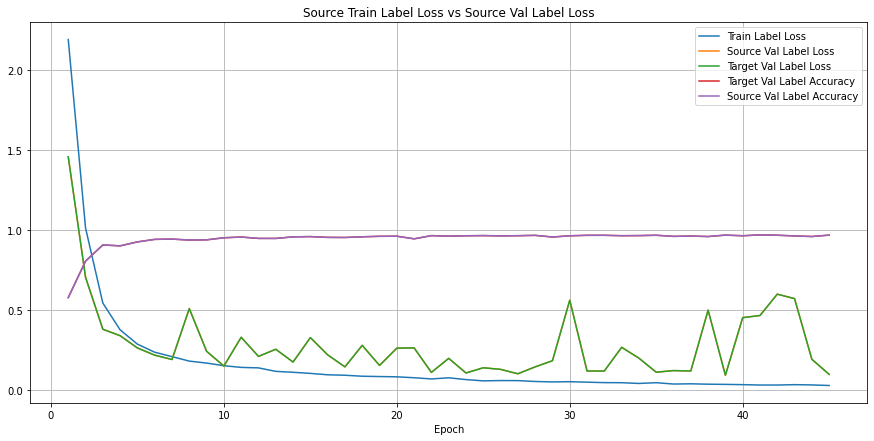

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

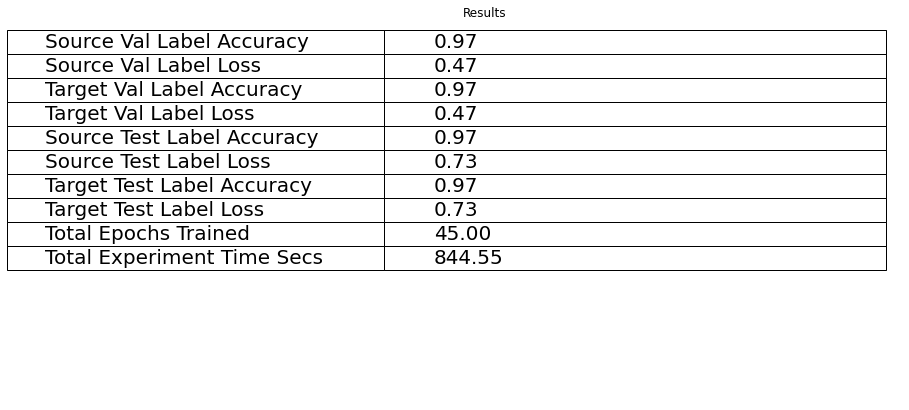

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

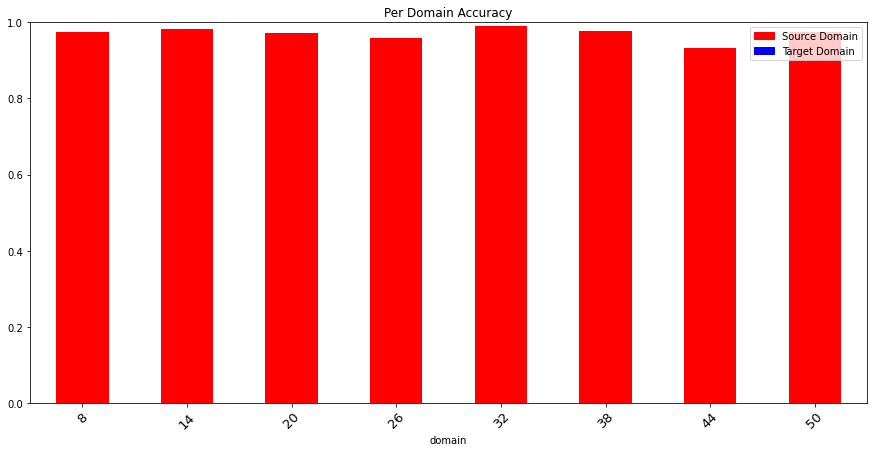

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.971953125 Target Test Label Accuracy: 0.971953125
Source Val Label Accuracy: 0.9704166666666667 Target Val Label Accuracy: 0.9704166666666667


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run1.framed", "parameters": {"experiment_name": "cnn_2:oracle.run1.framed", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_ch